Importing Libraries

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import geopandas as gpd
import seaborn as sns
import sklearn
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, GridSearchCV, validation_curve
from sklearn import preprocessing # Import label encoder 
from sklearn.preprocessing import StandardScaler

import statsmodels.api as sm

pd.set_option('display.max_rows', 300) # specifies number of rows to show
pd.options.display.float_format = '{:40,.4f}'.format # specifies default number format to 4 decimal places
plt.style.use('ggplot') # specifies that graphs should use ggplot styling
%matplotlib inline

In [3]:
import warnings
warnings.filterwarnings("ignore")

**Jumping to final merged data -FIRMS and ACLED data**


In [18]:
merged_fire_acled = pd.read_csv("acled_fire_combined_2004_2024.csv", encoding = "latin1")

In [19]:
merged_fire_acled

,grid_id,year,fireCount,acled_count,geo_acled,geo_fire
0,"48,28",2004,9,0,"{""geodesic"":false,""crs"":{""type"":""name"",""proper...","{""geodesic"":false,""crs"":{""type"":""name"",""proper..."
1,"48,29",2004,4,2,"{""geodesic"":false,""crs"":{""type"":""name"",""proper...","{""geodesic"":false,""crs"":{""type"":""name"",""proper..."
2,"49,27",2004,7,0,"{""geodesic"":false,""crs"":{""type"":""name"",""proper...","{""geodesic"":false,""crs"":{""type"":""name"",""proper..."
3,"49,28",2004,12,0,"{""geodesic"":false,""crs"":{""type"":""name"",""proper...","{""geodesic"":false,""crs"":{""type"":""name"",""proper..."
4,"49,29",2004,10,50,"{""geodesic"":false,""crs"":{""type"":""name"",""proper...","{""geodesic"":false,""crs"":{""type"":""name"",""proper..."
...,...,...,...,...,...,...
17845,"84,41",2024,2,0,"{""geodesic"":false,""crs"":{""type"":""name"",""proper...","{""geodesic"":false,""crs"":{""type"":""name"",""proper..."
17846,"84,42",2024,0,0,"{""geodesic"":false,""crs"":{""type"":""name"",""proper...","{""geodesic"":false,""crs"":{""type"":""name"",""proper..."
17847,"85,39",2024,0,0,"{""geodesic"":false,""crs"":{""type"":""name"",""proper...","{""geodesic"":false,""crs"":{""type"":""name"",""proper..."
17848,"85,40",2024,0,0,"{""geodesic"":false,""crs"":{""type"":""name"",""proper...","{""geodesic"":false,""crs"":{""type"":""name"",""proper..."


In [20]:
#Counting Null values by Column
merged_fire_acled.isnull().sum(axis=0).sort_values(ascending=False)[:12]

grid_id        0
year           0
fireCount      0
acled_count    0
geo_acled      0
geo_fire       0
dtype: int64

In [21]:
#Counting Null values by Rows
merged_fire_acled.isnull().sum(axis=1).sort_values(ascending=False).head(20)

0        0
11897    0
11903    0
11902    0
11901    0
11900    0
11899    0
11898    0
11896    0
11888    0
11895    0
11894    0
11893    0
11892    0
11891    0
11890    0
11904    0
11905    0
11906    0
11907    0
dtype: int64

In [22]:
# Converting the JSON strings to dictionaries for proper comparison
merged_fire_acled['geo_acled'] = merged_fire_acled['geo_acled'].apply(json.loads)
merged_fire_acled['geo_fire'] = merged_fire_acled['geo_fire'].apply(json.loads)

# Checking if the geo_acled and geo_fire columns are the same
merged_fire_acled['geo_equal'] = merged_fire_acled['geo_acled'] == merged_fire_acled['geo_fire']

# Display the DataFrame with the comparison result
print(merged_fire_acled)

      grid_id  year  fireCount  acled_count  \
0       48,28  2004          9            0   
1       48,29  2004          4            2   
2       49,27  2004          7            0   
3       49,28  2004         12            0   
4       49,29  2004         10           50   
...       ...   ...        ...          ...   
17845   84,41  2024          2            0   
17846   84,42  2024          0            0   
17847   85,39  2024          0            0   
17848   85,40  2024          0            0   
17849   85,41  2024          1            0   

                                               geo_acled  \
0      {'geodesic': False, 'crs': {'type': 'name', 'p...   
1      {'geodesic': False, 'crs': {'type': 'name', 'p...   
2      {'geodesic': False, 'crs': {'type': 'name', 'p...   
3      {'geodesic': False, 'crs': {'type': 'name', 'p...   
4      {'geodesic': False, 'crs': {'type': 'name', 'p...   
...                                                  ...   
17845  {'geodes

In [24]:
from shapely.geometry import shape
# If all geo_equal are True, use geo_acled for creating GeoDataFrame
if merged_fire_acled['geo_equal'].all():
    # Convert the 'geo_acled' column to shapely geometries
    merged_fire_acled['geometry'] = merged_fire_acled['geo_acled'].apply(lambda x: shape(x))

    # Create a GeoDataFrame
    gdf = gpd.GeoDataFrame(merged_fire_acled, geometry='geometry')

    # Display the GeoDataFrame
    print(gdf)
else:
    print("The geo_acled and geo_fire columns are not all the same.")

      grid_id  year  fireCount  acled_count  \
0       48,28  2004          9            0   
1       48,29  2004          4            2   
2       49,27  2004          7            0   
3       49,28  2004         12            0   
4       49,29  2004         10           50   
...       ...   ...        ...          ...   
17845   84,41  2024          2            0   
17846   84,42  2024          0            0   
17847   85,39  2024          0            0   
17848   85,40  2024          0            0   
17849   85,41  2024          1            0   

                                               geo_acled  \
0      {'geodesic': False, 'crs': {'type': 'name', 'p...   
1      {'geodesic': False, 'crs': {'type': 'name', 'p...   
2      {'geodesic': False, 'crs': {'type': 'name', 'p...   
3      {'geodesic': False, 'crs': {'type': 'name', 'p...   
4      {'geodesic': False, 'crs': {'type': 'name', 'p...   
...                                                  ...   
17845  {'geodes

In [25]:
gdf

,grid_id,year,fireCount,acled_count,geo_acled,geo_fire,geo_equal,geometry
0,"48,28",2004,9,0,"{'geodesic': False, 'crs': {'type': 'name', 'p...","{'geodesic': False, 'crs': {'type': 'name', 'p...",True,"POLYGON ((21.55957 12.57641, 22.00872 12.57641..."
1,"48,29",2004,4,2,"{'geodesic': False, 'crs': {'type': 'name', 'p...","{'geodesic': False, 'crs': {'type': 'name', 'p...",True,"POLYGON ((21.55957 13.02557, 22.00872 13.02557..."
2,"49,27",2004,7,0,"{'geodesic': False, 'crs': {'type': 'name', 'p...","{'geodesic': False, 'crs': {'type': 'name', 'p...",True,"POLYGON ((22.00872 12.12726, 22.45788 12.12726..."
3,"49,28",2004,12,0,"{'geodesic': False, 'crs': {'type': 'name', 'p...","{'geodesic': False, 'crs': {'type': 'name', 'p...",True,"POLYGON ((22.00872 12.57641, 22.45788 12.57641..."
4,"49,29",2004,10,50,"{'geodesic': False, 'crs': {'type': 'name', 'p...","{'geodesic': False, 'crs': {'type': 'name', 'p...",True,"POLYGON ((22.00872 13.02557, 22.45788 13.02557..."
...,...,...,...,...,...,...,...,...
17845,"84,41",2024,2,0,"{'geodesic': False, 'crs': {'type': 'name', 'p...","{'geodesic': False, 'crs': {'type': 'name', 'p...",True,"POLYGON ((37.72924 18.41546, 38.17840 18.41546..."
17846,"84,42",2024,0,0,"{'geodesic': False, 'crs': {'type': 'name', 'p...","{'geodesic': False, 'crs': {'type': 'name', 'p...",True,"POLYGON ((37.72924 18.86462, 38.17840 18.86462..."
17847,"85,39",2024,0,0,"{'geodesic': False, 'crs': {'type': 'name', 'p...","{'geodesic': False, 'crs': {'type': 'name', 'p...",True,"POLYGON ((38.17840 17.51715, 38.62756 17.51715..."
17848,"85,40",2024,0,0,"{'geodesic': False, 'crs': {'type': 'name', 'p...","{'geodesic': False, 'crs': {'type': 'name', 'p...",True,"POLYGON ((38.17840 17.96631, 38.62756 17.96631..."


In [29]:
gdf=gdf.drop(columns=['geo_acled','geo_fire','geo_equal'])

In [30]:
gdf

,grid_id,year,fireCount,acled_count,geometry
0,"48,28",2004,9,0,"POLYGON ((21.55957 12.57641, 22.00872 12.57641..."
1,"48,29",2004,4,2,"POLYGON ((21.55957 13.02557, 22.00872 13.02557..."
2,"49,27",2004,7,0,"POLYGON ((22.00872 12.12726, 22.45788 12.12726..."
3,"49,28",2004,12,0,"POLYGON ((22.00872 12.57641, 22.45788 12.57641..."
4,"49,29",2004,10,50,"POLYGON ((22.00872 13.02557, 22.45788 13.02557..."
...,...,...,...,...,...
17845,"84,41",2024,2,0,"POLYGON ((37.72924 18.41546, 38.17840 18.41546..."
17846,"84,42",2024,0,0,"POLYGON ((37.72924 18.86462, 38.17840 18.86462..."
17847,"85,39",2024,0,0,"POLYGON ((38.17840 17.51715, 38.62756 17.51715..."
17848,"85,40",2024,0,0,"POLYGON ((38.17840 17.96631, 38.62756 17.96631..."


In [31]:
gdf.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 17850 entries, 0 to 17849
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   grid_id      17850 non-null  object  
 1   year         17850 non-null  int64   
 2   fireCount    17850 non-null  int64   
 3   acled_count  17850 non-null  int64   
 4   geometry     17850 non-null  geometry
dtypes: geometry(1), int64(3), object(1)
memory usage: 697.4+ KB


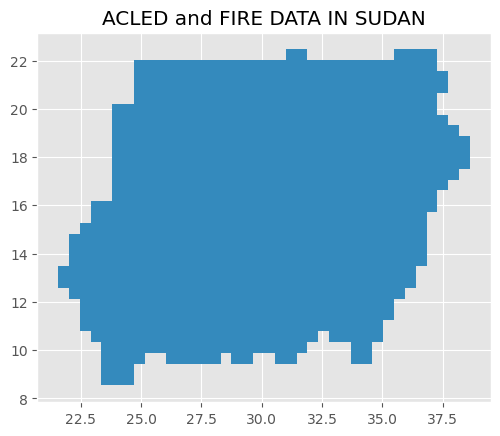

In [32]:
#Plotting the data
gdf.plot()
plt.title('ACLED and FIRE DATA IN SUDAN')
plt.show()

In [39]:
print(gdf.crs)

None


**Setting the CRS**

In [40]:
gdf.set_crs(epsg=4326, inplace=True)

,grid_id,year,fireCount,acled_count,geometry
0,"48,28",2004,9,0,"POLYGON ((21.55957 12.57641, 22.00872 12.57641..."
1,"48,29",2004,4,2,"POLYGON ((21.55957 13.02557, 22.00872 13.02557..."
2,"49,27",2004,7,0,"POLYGON ((22.00872 12.12726, 22.45788 12.12726..."
3,"49,28",2004,12,0,"POLYGON ((22.00872 12.57641, 22.45788 12.57641..."
4,"49,29",2004,10,50,"POLYGON ((22.00872 13.02557, 22.45788 13.02557..."
...,...,...,...,...,...
17845,"84,41",2024,2,0,"POLYGON ((37.72924 18.41546, 38.17840 18.41546..."
17846,"84,42",2024,0,0,"POLYGON ((37.72924 18.86462, 38.17840 18.86462..."
17847,"85,39",2024,0,0,"POLYGON ((38.17840 17.51715, 38.62756 17.51715..."
17848,"85,40",2024,0,0,"POLYGON ((38.17840 17.96631, 38.62756 17.96631..."


**Making Two separate interactive Maps for FIRMS and ACLED**

In [41]:
import folium
from branca.colormap import LinearColormap

# Print the current CRS
print("Current CRS:", gdf.crs)

# If CRS is None, set it (replace xxxx with the correct EPSG code)
if gdf.crs is None:
    gdf.set_crs(epsg=xxxx, inplace=True)
    print("CRS set to:", gdf.crs)

# Assuming your geodataframe is named 'gdf'
# Convert the GeoDataFrame to WGS84 coordinate system if it's not already
gdf = gdf.to_crs(epsg=4326)

# Calculate the center of the map
center_lat = gdf.geometry.centroid.y.mean()
center_lon = gdf.geometry.centroid.x.mean()

# Function to create a map
def create_map(data, column, title, colors):
    m = folium.Map(location=[center_lat, center_lon], zoom_start=6)
    
    colormap = LinearColormap(colors=colors, vmin=data[column].min(), vmax=data[column].max())
    
    for idx, row in data.iterrows():
        color = colormap(row[column])
        
        folium.GeoJson(
            row['geometry'],
            style_function=lambda x, color=color: {
                'fillColor': color,
                'color': 'black',
                'weight': 1,
                'fillOpacity': 0.7
            },
            tooltip=f"{title}: {row[column]}"
        ).add_to(m)
    
    colormap.add_to(m)
    m.save(f'{title.lower().replace(" ", "_")}_map.html')
    print(f"Interactive {title} map saved as '{title.lower().replace(' ', '_')}_map.html'")

# Create Fire Count Map
create_map(gdf, 'fireCount', 'Fire Count', ['yellow', 'orange', 'red'])

# Create ACLED Count Map
create_map(gdf, 'acled_count', 'ACLED Count', ['lightblue', 'blue', 'darkblue'])

Current CRS: EPSG:4326
Interactive Fire Count map saved as 'fire_count_map.html'
Interactive ACLED Count map saved as 'acled_count_map.html'


As we can see in the map we got of sudan there are no fires in the Northern part of Country. As it all deserted area most of the fires are at populated areas ---compared to Sudan population.

**Dropping Rows with zero firecount**

In [42]:
# Print the original number of rows
print("Original number of rows:", len(gdf))

# Filter out rows where fireCount is 0 and update the GeoDataFrame
gdf_filter = gdf[gdf['fireCount'] > 0]

# Print the number of rows after filtering
print("Number of rows after filtering:", len(gdf_filter))

Original number of rows: 17850
Number of rows after filtering: 6947


In [43]:
gdf_filter

,grid_id,year,fireCount,acled_count,geometry
0,"48,28",2004,9,0,"POLYGON ((21.55957 12.57641, 22.00872 12.57641..."
1,"48,29",2004,4,2,"POLYGON ((21.55957 13.02557, 22.00872 13.02557..."
2,"49,27",2004,7,0,"POLYGON ((22.00872 12.12726, 22.45788 12.12726..."
3,"49,28",2004,12,0,"POLYGON ((22.00872 12.57641, 22.45788 12.57641..."
4,"49,29",2004,10,50,"POLYGON ((22.00872 13.02557, 22.45788 13.02557..."
...,...,...,...,...,...
17826,"82,43",2024,1,45,"POLYGON ((36.83093 19.31378, 37.28008 19.31378..."
17834,"83,38",2024,1,0,"POLYGON ((37.28008 17.06799, 37.72924 17.06799..."
17844,"84,40",2024,1,0,"POLYGON ((37.72924 17.96631, 38.17840 17.96631..."
17845,"84,41",2024,2,0,"POLYGON ((37.72924 18.41546, 38.17840 18.41546..."


In [44]:
gdf_filter.describe()

,year,fireCount,acled_count
count,"6,947.0000","6,947.0000","6,947.0000"
mean,"2,014.3682",8.5551,5.5385
std,6.1386,7.4448,78.8379
min,"2,004.0000",1.0000,0.0000
25%,"2,009.0000",2.0000,0.0000
50%,"2,015.0000",6.0000,0.0000
75%,"2,020.0000",13.0000,0.0000
max,"2,024.0000",44.0000,"5,867.0000"


**Doing some Regression Analysis**

In [47]:
# Prepare the data for regression
X = gdf_filter['acled_count']  # Independent variable
y = gdf_filter['fireCount']    # Dependent variable

In [48]:
# Add a constant term to the independent variable
X = sm.add_constant(X)

# Fit the regression model
model = sm.OLS(y, X).fit()

# Print the summary of the regression
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:              fireCount   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                    0.5155
Date:                Sat, 27 Jul 2024   Prob (F-statistic):              0.473
Time:                        23:31:19   Log-Likelihood:                -23803.
No. Observations:                6947   AIC:                         4.761e+04
Df Residuals:                    6945   BIC:                         4.762e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const           8.5596      0.090     95.590      

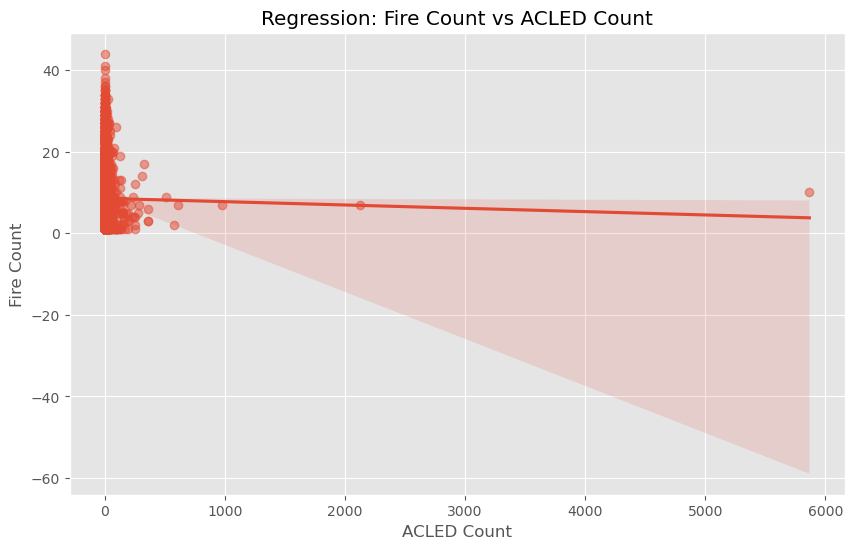

In [49]:
# Create a scatter plot with regression line
plt.figure(figsize=(10, 6))
sns.regplot(x='acled_count', y='fireCount', data=gdf_filter, scatter_kws={'alpha':0.5})
plt.title('Regression: Fire Count vs ACLED Count')
plt.xlabel('ACLED Count')
plt.ylabel('Fire Count')
plt.show()

In [50]:
# Print additional statistics
print(f"R-squared: {model.rsquared:.4f}")
print(f"Adjusted R-squared: {model.rsquared_adj:.4f}")
print(f"F-statistic: {model.fvalue:.4f}")
print(f"Prob (F-statistic): {model.f_pvalue:.4f}")

# Print coefficients
print("\nCoefficients:")
print(f"Intercept: {model.params[0]:.4f}")
print(f"ACLED Count: {model.params[1]:.4f}")

# Print p-values
print("\np-values:")
print(f"Intercept: {model.pvalues[0]:.4f}")
print(f"ACLED Count: {model.pvalues[1]:.4f}")

R-squared: 0.0001
Adjusted R-squared: -0.0001
F-statistic: 0.5155
Prob (F-statistic): 0.4728

Coefficients:
Intercept: 8.5596
ACLED Count: -0.0008

p-values:
Intercept: 0.0000
ACLED Count: 0.4728


R-squared: 0.000

This indicates that there is essentially no linear relationship between ACLED count and fire count. The model explains 0% of the variability in fire count.


Adj. R-squared: -0.000

The adjusted R-squared is also effectively zero, confirming the lack of explanatory power.


F-statistic: 0.5155 with Prob (F-statistic): 0.473

This high p-value (> 0.05) suggests that the model is not statistically significant.


Coefficients:

Intercept (const): 8.5596

This is the expected fire count when ACLED count is zero.


acled_count: -0.0008

For each unit increase in ACLED count, the fire count is expected to decrease by 0.0008. However, this is not statistically significant.




P-values:

Intercept: 0.000 (statistically significant)
acled_count: 0.473 (not statistically significant, as it's > 0.05)


Durbin-Watson: 1.052

This value is below 2, suggesting positive autocorrelation in the residuals.


Jarque-Bera (JB) test: 1252.156 with Prob(JB): 1.25e-272

This very low p-value suggests that the residuals are not normally distributed.



Interpretation:

There is no significant linear relationship between ACLED count and fire count.
The model has no explanatory power (R-squared ≈ 0).
The coefficient for ACLED count is not statistically significant (p-value > 0.05).
The residuals show signs of autocorrelation and are not normally distributed, which violates some assumptions of OLS regression.

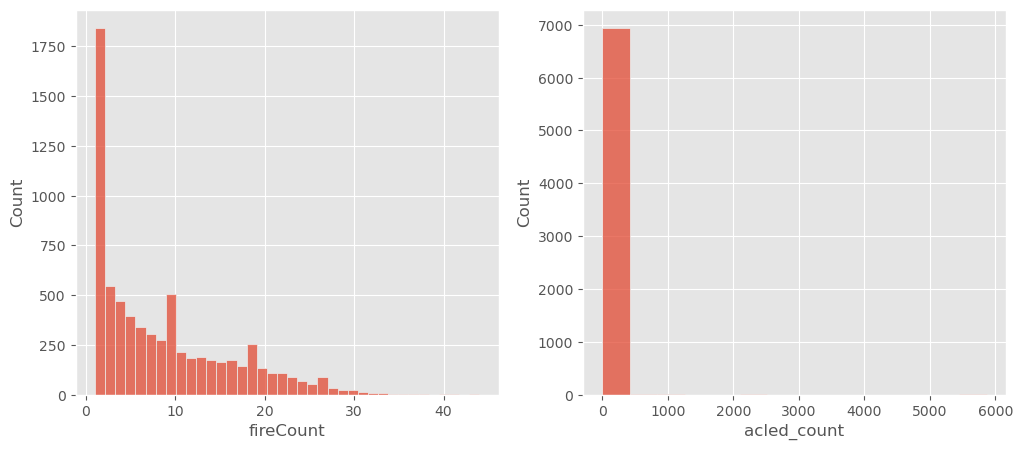

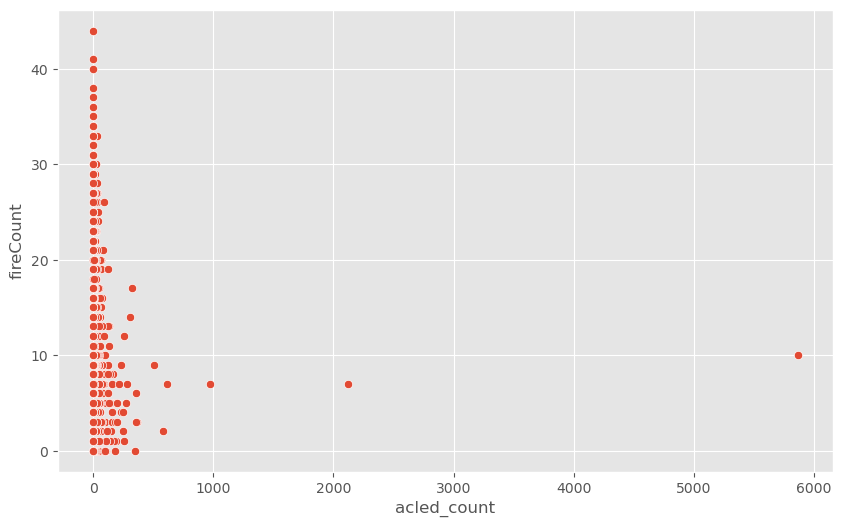

In [51]:
# Histograms
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
sns.histplot(gdf_filter['fireCount'], ax=ax1)
sns.histplot(gdf_filter['acled_count'], ax=ax2)
plt.show()

# Scatter plot
plt.figure(figsize=(10, 6))
sns.scatterplot(x='acled_count', y='fireCount', data=gdf)
plt.show()

In [52]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

X = gdf_filter[['acled_count']]
y = gdf_filter['fireCount']

for degree in [2, 3, 4]:
    poly_features = PolynomialFeatures(degree=degree, include_bias=False)
    X_poly = poly_features.fit_transform(X)
    
    model = LinearRegression()
    model.fit(X_poly, y)
    
    y_pred = model.predict(X_poly)
    r2 = r2_score(y, y_pred)
    
    print(f"Polynomial Regression (degree {degree}) R-squared: {r2:.4f}")

Polynomial Regression (degree 2) R-squared: 0.0008
Polynomial Regression (degree 3) R-squared: 0.0013
Polynomial Regression (degree 4) R-squared: 0.0015


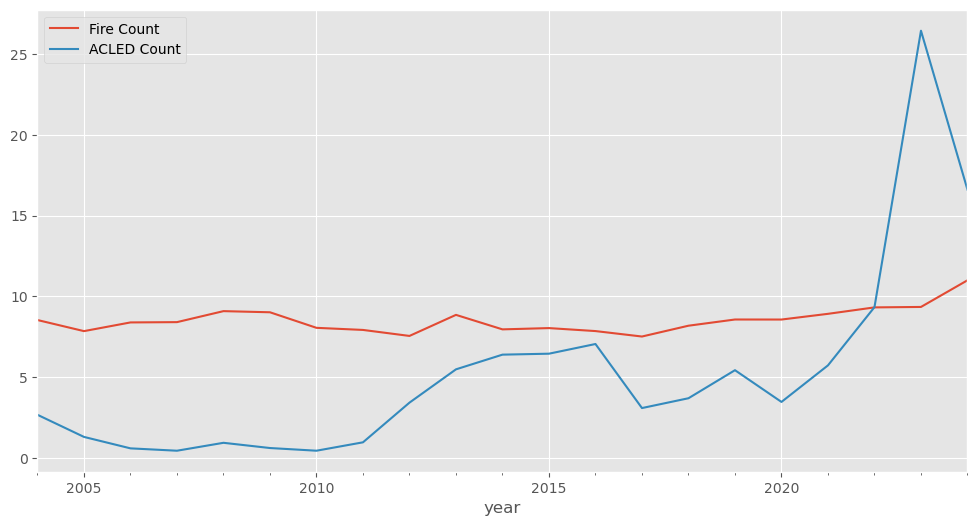

In [53]:
gdf_filter['year'] = pd.to_datetime(gdf_filter['year'], format='%Y')
gdf_filter.set_index('year', inplace=True)

# Time series plot
plt.figure(figsize=(12, 6))
gdf_filter.groupby(gdf_filter.index)['fireCount'].mean().plot()
gdf_filter.groupby(gdf_filter.index)['acled_count'].mean().plot()
plt.legend(['Fire Count', 'ACLED Count'])
plt.show()

Moran's I for fire count: 0.5981
p-value: 0.0010


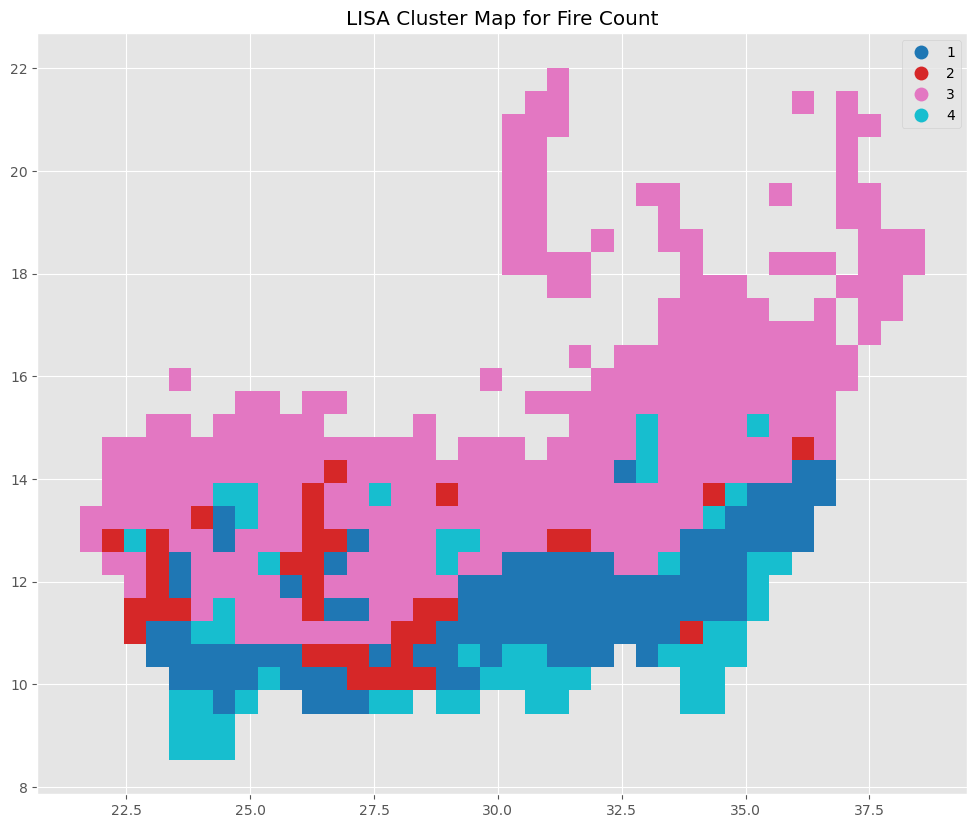

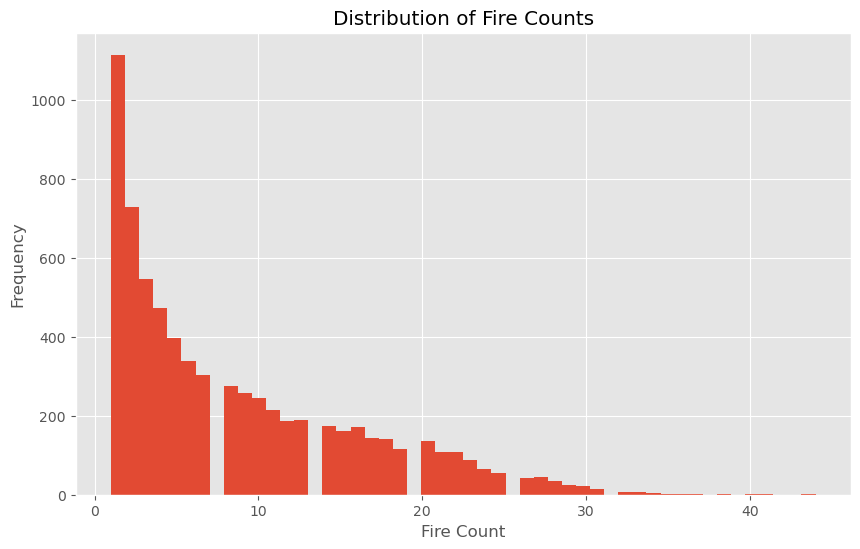

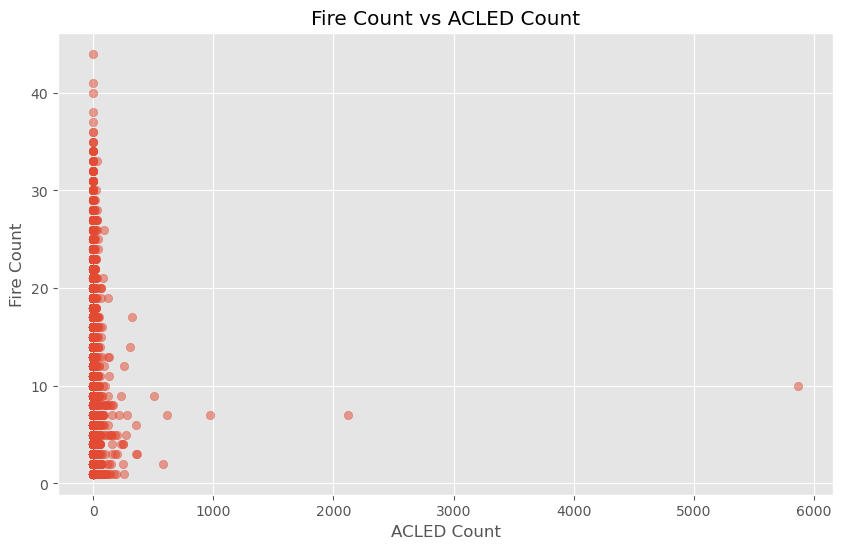


Moran's I for ACLED count: 0.2109
p-value: 0.0010


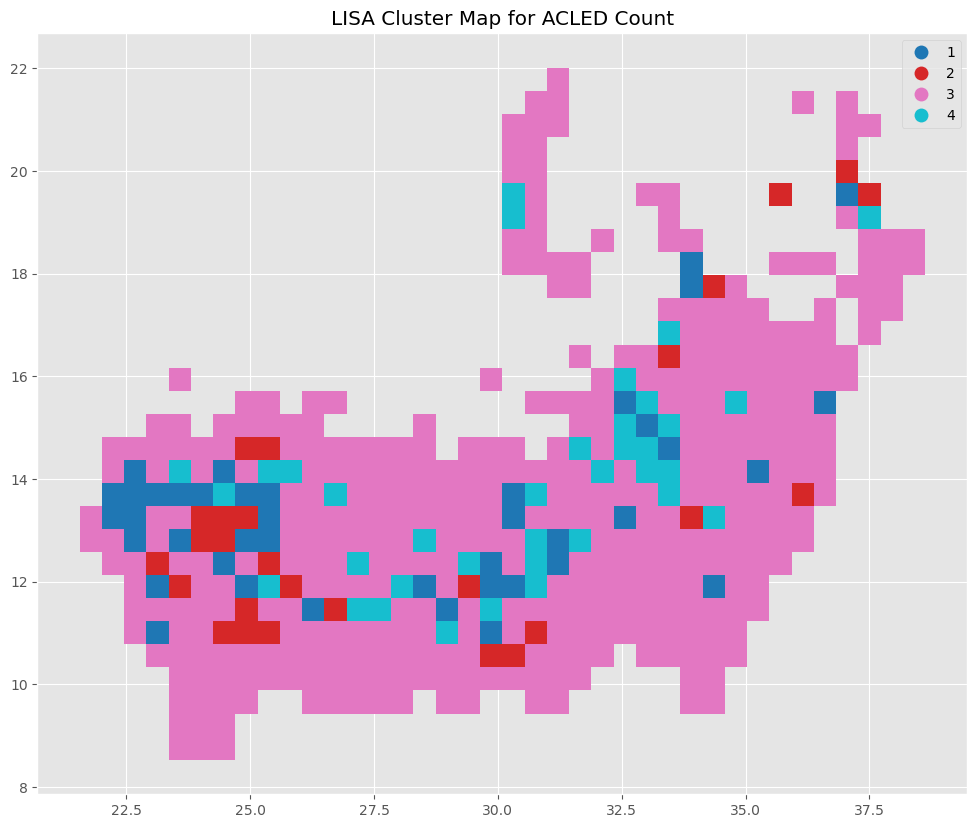

In [55]:
import geopandas as gpd
import matplotlib.pyplot as plt
from pysal.explore import esda
from pysal.lib import weights
import numpy as np

# First, let's reset the index of your GeoDataFrame to ensure consecutive integers
gdf_filter = gdf_filter.reset_index(drop=True)

# Now, let's create the spatial weights matrix
w = weights.distance.KNN.from_dataframe(gdf_filter, k=5)

# Calculate Moran's I for fire count
moran = esda.Moran(gdf_filter['fireCount'], w)
print(f"Moran's I for fire count: {moran.I:.4f}")
print(f"p-value: {moran.p_sim:.4f}")

# Local Indicators of Spatial Association (LISA)
lisa = esda.Moran_Local(gdf_filter['fireCount'], w)

# Plot LISA cluster map
gdf_filter['lisa_cluster'] = lisa.q
fig, ax = plt.subplots(figsize=(12, 10))
gdf_filter.plot(column='lisa_cluster', categorical=True, legend=True, ax=ax)
ax.set_title('LISA Cluster Map for Fire Count')
plt.show()

# Let's also look at the distribution of fire counts
plt.figure(figsize=(10, 6))
gdf_filter['fireCount'].hist(bins=50)
plt.title('Distribution of Fire Counts')
plt.xlabel('Fire Count')
plt.ylabel('Frequency')
plt.show()

# And the relationship between fire count and ACLED count
plt.figure(figsize=(10, 6))
plt.scatter(gdf_filter['acled_count'], gdf_filter['fireCount'], alpha=0.5)
plt.title('Fire Count vs ACLED Count')
plt.xlabel('ACLED Count')
plt.ylabel('Fire Count')
plt.show()

# Let's also check for any spatial patterns in ACLED count
moran_acled = esda.Moran(gdf_filter['acled_count'], w)
print(f"\nMoran's I for ACLED count: {moran_acled.I:.4f}")
print(f"p-value: {moran_acled.p_sim:.4f}")

# And create a LISA cluster map for ACLED count
lisa_acled = esda.Moran_Local(gdf_filter['acled_count'], w)
gdf_filter['lisa_cluster_acled'] = lisa_acled.q
fig, ax = plt.subplots(figsize=(12, 10))
gdf_filter.plot(column='lisa_cluster_acled', categorical=True, legend=True, ax=ax)
ax.set_title('LISA Cluster Map for ACLED Count')
plt.show()